In [1]:
import jax

In [2]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)]

In [3]:
import jax.numpy as jnp
from jax import random

In [4]:
x = random.normal(random.PRNGKey(0), (5_000, 5_000))

print(x.shape)
print(x.dtype)

(5000, 5000)
float32


In [5]:
x

Array([[-0.11661171,  0.8242215 , -1.2445085 , ..., -1.8854173 ,
         0.41252783, -0.961976  ],
       [ 1.8455055 , -0.30786476, -1.0153097 , ..., -0.01620289,
         2.0080993 , -0.9451337 ],
       [-0.67672527,  0.4280688 , -0.46904287, ...,  0.7997399 ,
         0.10403793, -1.2848098 ],
       ...,
       [ 0.60997057, -1.3257729 , -0.86143535, ..., -2.6257322 ,
        -1.2271131 ,  0.61286527],
       [ 1.0326647 ,  0.592573  , -0.10977031, ...,  0.2430163 ,
        -0.5956606 , -1.4219506 ],
       [ 2.1604197 , -0.2298865 , -1.0518851 , ...,  1.6659708 ,
        -0.31161797,  1.3135116 ]], dtype=float32)

In [7]:
y = jnp.dot(x, jnp.cos(x))
z = y[[0, 2, 1, 0], ..., None, ::-1]

print(z)

[[[ -6.0566964  53.154293   47.546646  ... -32.643036   23.932243
   -32.559704 ]]

 [[ -2.876449   14.091277   28.160069  ...  72.67386    30.46049
    54.96488  ]]

 [[-58.108154  -35.2848    -48.49509   ... -32.48123   -15.550288
     3.571836 ]]

 [[ -6.0566964  53.154293   47.546646  ... -32.643036   23.932243
   -32.559704 ]]]


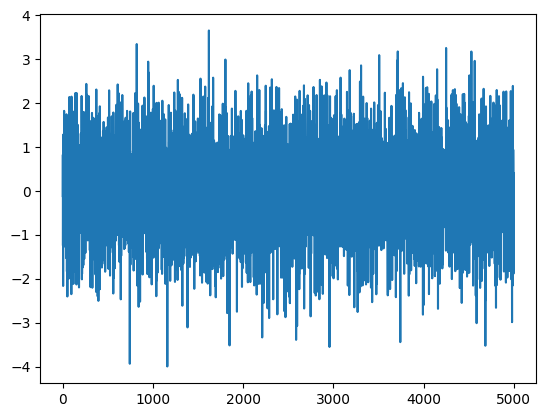

In [8]:
import matplotlib.pyplot as plt

plt.plot(x[0])